# Load Library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
import math
from sklearn import preprocessing
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from operator import mul
from scipy.spatial import distance
import seaborn as sns
import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense,Multiply,Add, concatenate
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_recall_curve,roc_auc_score,precision_score

# Data Load

In [2]:
te = pd.read_csv('text_vectors_train.csv') # Doc2vec으로 뽑은 10차원의 Vector들
te.drop('Unnamed: 0',axis=1,inplace=True)

images = pd.read_csv('img_vecs.csv') # CNN으로 뽑은 10차원의 Vector들
images.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
label = pd.read_csv('train_label.csv')
Y = label['supercategory']

In [4]:
data = pd.concat([te,images],axis=1)
data.reset_index(drop=True,inplace=True)


text = data.iloc[:,:250]
img = data.iloc[:,250:]

text.columns=range(0,250)
img .columns=range(0,250)

text['img=1']=0
img['img=1']=1

d_for_eda = pd.concat([text,img],axis=0)

# Original Distribution Visualize

In [5]:
x = d_for_eda.drop(['img=1'],axis=1)
y = d_for_eda['img=1']

x.reset_index(drop=True,inplace=True)

In [6]:
# PCA로 2차원으로 줄인 후, 시각화하는 함수 선언
def plot_3d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E','#00FFFF']
    markers = ['o', 's','d']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            X[y==l, 2],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [7]:
# PCA로 2차원으로 줄인 후, 시각화하는 함수 선언
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

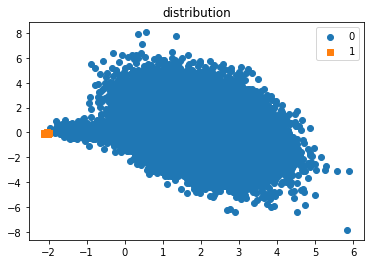

In [8]:
# 원본 데이터 분포
pca = PCA(n_components=2)
X = pca.fit_transform(x)
plot_2d_space(X, y, 'distribution')

# Vector Nomalize

In [9]:
d_for_eda.drop('img=1',axis=1,inplace=True)

norm_vec=[]
for i in tqdm(range(0,len(d_for_eda))):
    dot = d_for_eda.iloc[i:i+1,:].values
    norm = np.sqrt(np.dot(dot[0],dot[0]))
    scaled = (dot[0] / norm)
    norm_vec.append(scaled)

norm_vec = pd.DataFrame(np.array(norm_vec).reshape(len(data)*2,250))

100%|███████████████████████████████████████████████████████████████████████| 236574/236574 [00:10<00:00, 22556.73it/s]


In [10]:
norm_vec.reset_index(drop=True,inplace=True)


text_norm = norm_vec.iloc[:len(te),:]
img_norm = norm_vec.iloc[len(te):,:]

text_norm.columns=range(0,250)
img_norm .columns=range(0,250)

# Nomalized Vector distribution Visualize

C:\Users\user\AppData\Local\Temp/ipykernel_26592/1158323884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_norm['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_26592/1158323884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img_norm['img=1']=1


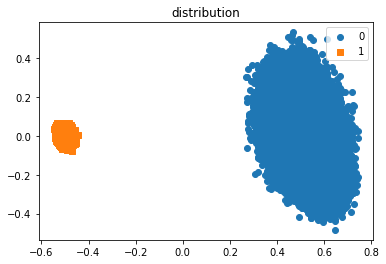

In [11]:
text_norm['img=1']=0
img_norm['img=1']=1
d_for_eda = pd.concat([text_norm,img_norm],axis=0)

x = d_for_eda.drop(['img=1'],axis=1)
y = d_for_eda['img=1']

x.reset_index(drop=True,inplace=True)

pca = PCA(n_components=2)
X = pca.fit_transform(x)
plot_2d_space(X, y, 'distribution')

# Original Data Statisitical Distribution

<AxesSubplot:ylabel='Density'>

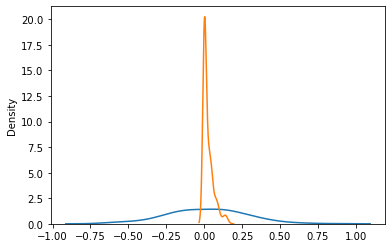

In [12]:
cv1 = te.mean()
cv2 = images.mean()

sns.kdeplot(cv1)
sns.kdeplot(cv2)

# Getting Weight and Implement Summation

In [13]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [14]:
def weighted_sum(text_vec,img_vec,text_norm,img_norm):
    # Getting Distance From Hyper Plane
    text_norm['img=1']=0
    img_norm['img=1']=1
    d_for_eda=pd.concat([text_norm,img_norm],axis=0)

    x = d_for_eda.drop('img=1',axis=1)
    y= d_for_eda['img=1']
    
    model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
    clf = model.fit(x, y)
    dis = clf.decision_function(x)
    
    dis = pd.DataFrame(dis,columns=['distance_ratio'])

    x.reset_index(drop=True,inplace=True)
    
    new = pd.concat([x,dis],axis=1)
    
    new['distance_ratio'] = abs(new['distance_ratio'])
    
    new.reset_index(drop=True,inplace=True)
    images.reset_index(drop=True,inplace=True)
    
    # Find a weight with a weight sum of 1

    new_te = new.iloc[:len(text_vec),:]
    new_img = new.iloc[len(text_vec):,:]
    new_img.reset_index(drop=True,inplace=True)
    
    div = new['distance_ratio'][:len(text_vec)].values+new['distance_ratio'][len(text_vec):].values    
    weisum = new_te['distance_ratio']*( new_te['distance_ratio'] / div)+new_img['distance_ratio']*( new_img['distance_ratio'] / div)

    img_norm.reset_index(drop=True,inplace=True)
    
    real_new=pd.concat([text_vec,img_vec],axis=1)
    real_new['con_dis'] = weisum

    x = real_new.drop(['con_dis'],axis=1)
    y = weisum
    
    inputs = Input(shape=(x.shape[1],))
    # MLP
    inputs = Input(shape=(x.shape[1],))
    Selection = Dense(x.shape[1], activation='sigmoid')(inputs)
    Selection = Model(inputs=inputs, outputs=Selection)
    Extraction = Dense(x.shape[1], activation='tanh')(inputs)
    Extraction = Model(inputs=inputs, outputs=Extraction)
    x_multiply = Multiply()([inputs,Selection.output])
    Added = Add()([x_multiply, Extraction.output])
    model = Model(inputs=inputs, outputs=Added)
    
    # 모델 컴파일
    model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['MSE'])
    
    # 모델 실행
    model.fit(x, y, epochs=100, batch_size=32)

    con_scalar=model.predict(x)
    con_scalar = pd.DataFrame(con_scalar)

    soft=[]
    for i in tqdm(range(0,len(con_scalar))):
        soft.append(softmax(con_scalar.iloc[i:i+1,:].values))
    new_one = pd.DataFrame(np.array(soft).reshape(len(con_scalar),500))
    
    text_scalar = new_one.iloc[:,:250]
    img_scalar = new_one.iloc[:,250:]
    
    # Multiply the weight by the distance again
    img_scalar.reset_index(drop=True,inplace=True)
    new.reset_index(drop=True,inplace=True)
    #for i in tqdm(range(0,len(text_vec))):
    #    text_scalar.iloc[i:i+1,:250] = text_scalar.iloc[i:i+1,:250]*(new_te['distance_ratio'][i])
    #    img_scalar.iloc[i:i+1,:250] = img_scalar.iloc[i:i+1,:250]*(new_img['distance_ratio'][i])
        
    # Weighted sum
    text_sum=text_vec*text_scalar.values
    img_sum= img_vec*img_scalar.values
    text_sum.reset_index(drop=True,inplace=True)
    img_sum.reset_index(drop=True,inplace=True)
    vectors=text_sum+img_sum
    return vectors

# Train Test Split

In [15]:
le = preprocessing.LabelEncoder()
le.fit(Y.values) #Y변수 Label Encoding해주기

y = le.transform(Y.values)

In [16]:
x_te_train,x_te_test,y_train,y_test = train_test_split(te,y,test_size=0.3,random_state=2022,stratify=y)
x_img_train,x_img_test,y_train,y_test= train_test_split(images,y,test_size=0.3,random_state=2022,stratify=y)

norm_te_train,norm_te_test,y_train,y_test = train_test_split(text_norm,y,test_size=0.3,random_state=2022,stratify=y)
norm_img_train,norm_img_test,y_train,y_test= train_test_split(img_norm,y,test_size=0.3,random_state=2022,stratify=y)

In [17]:
with tf.device("/device:CPU:0"):
    x_train = weighted_sum(x_te_train,x_img_train,norm_te_train,norm_img_train)
    x_test = weighted_sum(x_te_test,x_img_test,norm_te_test,norm_img_test)

Epoch 1/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0288 - MSE: 0.0288
Epoch 2/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0178 - MSE: 0.0178
Epoch 3/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0176 - MSE: 0.0176
Epoch 4/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0175 - MSE: 0.0175
Epoch 5/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0175 - MSE: 0.0175
Epoch 6/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0175 - MSE: 0.0175
Epoch 7/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0175 - MSE: 0.0175
Epoch 8/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0174 - MSE: 0.0174
Epoch 9/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0174 - MSE: 0.0174
Epoch 10/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0174 - MSE: 0.0174
Epoch 11/100
2588/2

2588/2588 [==============================] - 3s 1ms/step - loss: 0.0174 - MSE: 0.0174
Epoch 84/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0174 - MSE: 0.0174
Epoch 85/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0174 - MSE: 0.0174
Epoch 86/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0174 - MSE: 0.0174
Epoch 87/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0174 - MSE: 0.0174
Epoch 88/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0174 - MSE: 0.0174
Epoch 89/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0174 - MSE: 0.0174
Epoch 90/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0174 - MSE: 0.0174
Epoch 91/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0174 - MSE: 0.0174
Epoch 92/100
2588/2588 [==============================] - 3s 1ms/step - loss: 0.0174 - MSE: 0.0174
Epoch 93/100
2588/2588 

100%|█████████████████████████████████████████████████████████████████████████| 82800/82800 [00:04<00:00, 17931.19it/s]


Epoch 1/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0385 - MSE: 0.0385
Epoch 2/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0154 - MSE: 0.0154
Epoch 3/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0148 - MSE: 0.0148
Epoch 4/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0146 - MSE: 0.0146
Epoch 5/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0145 - MSE: 0.0145
Epoch 6/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0144 - MSE: 0.0144
Epoch 7/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0144 - MSE: 0.0144
Epoch 8/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0144 - MSE: 0.0144
Epoch 9/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0143 - MSE: 0.0143
Epoch 10/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0143 - MSE: 0.0143
Epoch 11/100
1109/1

1109/1109 [==============================] - 1s 1ms/step - loss: 0.0142 - MSE: 0.0142
Epoch 84/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0142 - MSE: 0.0142
Epoch 85/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0142 - MSE: 0.0142
Epoch 86/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0142 - MSE: 0.0142
Epoch 87/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0142 - MSE: 0.0142
Epoch 88/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0142 - MSE: 0.0142
Epoch 89/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0142 - MSE: 0.0142
Epoch 90/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0142 - MSE: 0.0142
Epoch 91/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0142 - MSE: 0.0142
Epoch 92/100
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0142 - MSE: 0.0142
Epoch 93/100
1109/1109 

100%|█████████████████████████████████████████████████████████████████████████| 35487/35487 [00:01<00:00, 17943.46it/s]


# Visualization after combining

<AxesSubplot:ylabel='Density'>

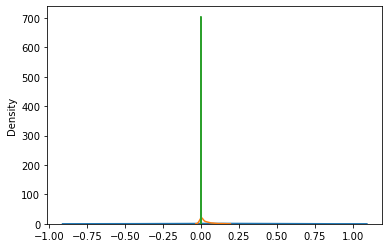

In [18]:
cv1 = te.mean()
cv2 = images.mean()
cv3 = x_train.mean()
sns.kdeplot(cv1)
sns.kdeplot(cv2)
sns.kdeplot(cv3)

In [19]:
te['img=1']=0
images['img=1']=1
x_train['img=1']=2

In [21]:
con = pd.concat([te,images,x_train],axis=0)
con.reset_index(drop=True,inplace=True)
x = con.drop(['img=1'],axis=1)
y = con['img=1'].values

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


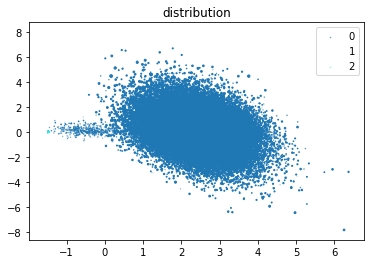

In [22]:
# 가중치 적용 후 분포 poly
pca = PCA(n_components=3)
X = pca.fit_transform(x)
plot_3d_space(X, y, 'distribution')

In [23]:
from sklearn.manifold import TSNE
# 축소한 차원의 수를 정합니다.
n_components = 2
# TSNE 모델의 인스턴스를 만듭니다.
model = TSNE(n_components=n_components)
# 2차원 t-SNE 임베딩
tsne_np = TSNE(n_components = 2).fit_transform(x)

# numpy array -> DataFrame 변환
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


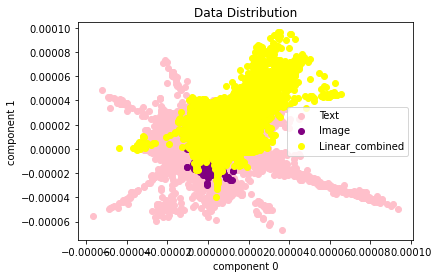

In [24]:
# class target 정보 불러오기 
tsne_df['target'] = con['img=1']

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]
tsne_df_2 = tsne_df[tsne_df['target'] == 2]

# target 별 시각화
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label = 'Text')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = 'Image')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = 'yellow', label = 'Linear_combined')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.title('Data Distribution')
plt.legend()
plt.show()

In [26]:
te.drop(['img=1'],axis=1,inplace=True)

images.drop(['img=1'],axis=1,inplace=True)
x_train.drop(['img=1'],axis=1,inplace=True)

# Run!

In [27]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [ ]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=250 , activation='relu'))
    model.add(Dense(13, activation='softmax'))
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train_encoded, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test_encoded)[1]))

Epoch 1/50
2588/2588 [==============================] - 2s 663us/step - loss: 2.1637 - accuracy: 0.3061
Epoch 2/50
2588/2588 [==============================] - 2s 661us/step - loss: 1.8808 - accuracy: 0.4120
Epoch 3/50
2588/2588 [==============================] - 2s 670us/step - loss: 1.7494 - accuracy: 0.4470
Epoch 4/50
2588/2588 [==============================] - 2s 664us/step - loss: 1.6803 - accuracy: 0.4682
Epoch 5/50
2588/2588 [==============================] - 2s 668us/step - loss: 1.6453 - accuracy: 0.4780
Epoch 6/50
2588/2588 [==============================] - 2s 680us/step - loss: 1.6238 - accuracy: 0.4857
Epoch 7/50
2588/2588 [==============================] - 2s 715us/step - loss: 1.6103 - accuracy: 0.4885
Epoch 8/50
2588/2588 [==============================] - 2s 667us/step - loss: 1.5972 - accuracy: 0.4945
Epoch 9/50
2588/2588 [==============================] - 2s 687us/step - loss: 1.5874 - accuracy: 0.4962
Epoch 10/50
2588/2588 [==============================] - 2s 660u

In [22]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict(x_test)
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.57      0.40      0.47      1487
           1       0.77      0.82      0.79      6317
           2       0.40      0.44      0.42       626
           3       0.58      0.33      0.42      1864
           4       0.48      0.51      0.50      1647
           5       0.50      0.44      0.47      3709
           6       0.53      0.43      0.48      1546
           7       0.37      0.34      0.35      2449
           8       0.45      0.26      0.33      1127
           9       0.51      0.64      0.57      6749
          10       0.57      0.30      0.39      1813
          11       0.63      0.77      0.69      5847
          12       0.42      0.23      0.30       306

    accuracy                           0.57     35487
   macro avg       0.52      0.46      0.48     35487
weighted avg       0.57      0.57      0.56     35487



In [23]:
recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "weighted")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))

정밀도: 0.5691, 재현율: 0.5745, f1_score: 0.5745


# DNN based approach

In [25]:
te_x_train,te_test,y_train,y_test = train_test_split(te,y,test_size=0.3,random_state=2022,stratify=y)

img_x_train,img_test,y_train,y_test = train_test_split(images,y,test_size=0.3,random_state=2022,stratify=y)

In [26]:
with tf.device("/device:CPU:0"):
    
    # MLP
    inputs_te= Input(shape=(te_x_train.shape[1],))
    inputs_img= Input(shape=(img_x_train.shape[1],))
    
    text_layer = Dense(te_x_train.shape[1], activation='relu')(inputs_te)
    img_layer = Dense(img_x_train.shape[1], activation='relu')(inputs_img)
    concat = concatenate([text_layer, img_layer])
    out = Dense(13, activation='softmax')(concat)
    model = Model(inputs=[inputs_te,inputs_img], outputs=out)
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit([te_x_train,img_x_train], y_train_encoded, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate((te_test.values,img_test.values), y_test_encoded)[1]))

Epoch 1/50
2588/2588 [==============================] - 2s 657us/step - loss: 1.5389 - accuracy: 0.5128
Epoch 2/50
2588/2588 [==============================] - 2s 657us/step - loss: 1.2739 - accuracy: 0.5914
Epoch 3/50
2588/2588 [==============================] - 2s 658us/step - loss: 1.1730 - accuracy: 0.6221
Epoch 4/50
2588/2588 [==============================] - 2s 668us/step - loss: 1.1024 - accuracy: 0.6393
Epoch 5/50
2588/2588 [==============================] - 2s 661us/step - loss: 1.0431 - accuracy: 0.6591
Epoch 6/50
2588/2588 [==============================] - 2s 661us/step - loss: 0.9945 - accuracy: 0.6738
Epoch 7/50
2588/2588 [==============================] - 2s 664us/step - loss: 0.9543 - accuracy: 0.6839
Epoch 8/50
2588/2588 [==============================] - 2s 662us/step - loss: 0.9179 - accuracy: 0.6931
Epoch 9/50
2588/2588 [==============================] - 2s 669us/step - loss: 0.8870 - accuracy: 0.7039
Epoch 10/50
2588/2588 [==============================] - 2s 699u

In [27]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict((te_test.values,img_test.values))
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "weighted")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))

              precision    recall  f1-score   support

           0       0.36      0.41      0.39      1487
           1       0.76      0.75      0.76      6317
           2       0.29      0.30      0.29       626
           3       0.39      0.40      0.39      1864
           4       0.42      0.48      0.44      1647
           5       0.38      0.39      0.38      3709
           6       0.43      0.40      0.41      1546
           7       0.30      0.25      0.28      2449
           8       0.34      0.30      0.32      1127
           9       0.48      0.51      0.49      6749
          10       0.38      0.35      0.36      1813
          11       0.66      0.65      0.66      5847
          12       0.20      0.27      0.23       306

    accuracy                           0.51     35487
   macro avg       0.42      0.42      0.42     35487
weighted avg       0.51      0.51      0.51     35487

정밀도: 0.5076, 재현율: 0.5070, f1_score: 0.5070


# Text only

In [31]:
x_train,x_test,y_train,y_test = train_test_split(te,y,test_size=0.3,random_state=2022,stratify=y)
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [32]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=250 , activation='relu'))
    model.add(Dense(13, activation='softmax'))
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train_encoded, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test_encoded)[1]))

Epoch 1/50
2588/2588 [==============================] - 2s 631us/step - loss: 1.5316 - accuracy: 0.5173
Epoch 2/50
2588/2588 [==============================] - 2s 641us/step - loss: 1.2649 - accuracy: 0.5959
Epoch 3/50
2588/2588 [==============================] - 2s 653us/step - loss: 1.1363 - accuracy: 0.6357
Epoch 4/50
2588/2588 [==============================] - 2s 655us/step - loss: 1.0328 - accuracy: 0.6640
Epoch 5/50
2588/2588 [==============================] - 2s 647us/step - loss: 0.9375 - accuracy: 0.6928
Epoch 6/50
2588/2588 [==============================] - 2s 662us/step - loss: 0.8564 - accuracy: 0.7163
Epoch 7/50
2588/2588 [==============================] - 2s 649us/step - loss: 0.7847 - accuracy: 0.7376
Epoch 8/50
2588/2588 [==============================] - 2s 655us/step - loss: 0.7194 - accuracy: 0.7567
Epoch 9/50
2588/2588 [==============================] - 2s 654us/step - loss: 0.6649 - accuracy: 0.7756
Epoch 10/50
2588/2588 [==============================] - 2s 651u

In [33]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict(x_test)
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "weighted")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))

              precision    recall  f1-score   support

           0       0.43      0.35      0.39      1487
           1       0.71      0.78      0.74      6317
           2       0.31      0.31      0.31       626
           3       0.34      0.38      0.35      1864
           4       0.43      0.36      0.39      1647
           5       0.37      0.37      0.37      3709
           6       0.44      0.39      0.41      1546
           7       0.28      0.30      0.29      2449
           8       0.35      0.30      0.32      1127
           9       0.48      0.49      0.48      6749
          10       0.35      0.36      0.35      1813
          11       0.66      0.63      0.65      5847
          12       0.25      0.20      0.22       306

    accuracy                           0.50     35487
   macro avg       0.42      0.40      0.41     35487
weighted avg       0.50      0.50      0.50     35487

정밀도: 0.4971, 재현율: 0.4999, f1_score: 0.4999


# Image only

In [34]:
le = preprocessing.LabelEncoder()
le.fit(Y.values) #Y변수 Label Encoding해주기

y = le.transform(Y.values)
x_train,x_test,y_train,y_test = train_test_split(images,y,test_size=0.3,random_state=2022,stratify=y)
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [35]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=250 , activation='relu'))
    model.add(Dense(13, activation='softmax'))
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train_encoded, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test_encoded)[1]))

Epoch 1/50
2588/2588 [==============================] - 2s 618us/step - loss: 2.1358 - accuracy: 0.2881
Epoch 2/50
2588/2588 [==============================] - 2s 624us/step - loss: 2.0283 - accuracy: 0.3239
Epoch 3/50
2588/2588 [==============================] - 2s 639us/step - loss: 2.0010 - accuracy: 0.3323
Epoch 4/50
2588/2588 [==============================] - 2s 633us/step - loss: 1.9868 - accuracy: 0.3358
Epoch 5/50
2588/2588 [==============================] - 2s 637us/step - loss: 1.9767 - accuracy: 0.3387
Epoch 6/50
2588/2588 [==============================] - 2s 635us/step - loss: 1.9688 - accuracy: 0.3411
Epoch 7/50
2588/2588 [==============================] - 2s 637us/step - loss: 1.9616 - accuracy: 0.3446
Epoch 8/50
2588/2588 [==============================] - 2s 635us/step - loss: 1.9549 - accuracy: 0.3457
Epoch 9/50
2588/2588 [==============================] - 2s 637us/step - loss: 1.9485 - accuracy: 0.3480
Epoch 10/50
2588/2588 [==============================] - 2s 637u

In [36]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict(x_test)
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "macro")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))

              precision    recall  f1-score   support

           0       0.40      0.04      0.08      1487
           1       0.44      0.53      0.48      6317
           2       0.13      0.02      0.04       626
           3       0.21      0.05      0.09      1864
           4       0.26      0.12      0.16      1647
           5       0.24      0.33      0.28      3709
           6       0.25      0.13      0.17      1546
           7       0.19      0.21      0.20      2449
           8       0.34      0.10      0.15      1127
           9       0.37      0.36      0.36      6749
          10       0.31      0.07      0.12      1813
          11       0.35      0.62      0.45      5847
          12       0.35      0.04      0.08       306

    accuracy                           0.34     35487
   macro avg       0.29      0.20      0.20     35487
weighted avg       0.33      0.34      0.31     35487

정밀도: 0.3268, 재현율: 0.3367, f1_score: 0.3367


# Concatanation Approach

In [37]:
train = pd.concat([te,images],axis=1)
x_train,x_test,y_train,y_test = train_test_split(train,y,test_size=0.3,random_state=2022,stratify=y)

In [38]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=500 , activation='relu'))
    model.add(Dense(13, activation='softmax'))
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train_encoded, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test_encoded)[1]))

Epoch 1/50
2588/2588 [==============================] - 2s 742us/step - loss: 1.5179 - accuracy: 0.5208
Epoch 2/50
2588/2588 [==============================] - 2s 753us/step - loss: 1.2459 - accuracy: 0.6022
Epoch 3/50
2588/2588 [==============================] - 2s 759us/step - loss: 1.1180 - accuracy: 0.6387
Epoch 4/50
2588/2588 [==============================] - 2s 745us/step - loss: 1.0106 - accuracy: 0.6703
Epoch 5/50
2588/2588 [==============================] - 2s 736us/step - loss: 0.9154 - accuracy: 0.6982
Epoch 6/50
2588/2588 [==============================] - 2s 746us/step - loss: 0.8307 - accuracy: 0.7242
Epoch 7/50
2588/2588 [==============================] - 2s 739us/step - loss: 0.7574 - accuracy: 0.7455
Epoch 8/50
2588/2588 [==============================] - 2s 741us/step - loss: 0.6919 - accuracy: 0.7665
Epoch 9/50
2588/2588 [==============================] - 2s 741us/step - loss: 0.6293 - accuracy: 0.7868
Epoch 10/50
2588/2588 [==============================] - 2s 737u

In [39]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict(x_test)
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "macro")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))

              precision    recall  f1-score   support

           0       0.40      0.39      0.40      1487
           1       0.74      0.78      0.76      6317
           2       0.33      0.31      0.32       626
           3       0.44      0.33      0.38      1864
           4       0.43      0.38      0.40      1647
           5       0.38      0.40      0.39      3709
           6       0.41      0.41      0.41      1546
           7       0.28      0.31      0.30      2449
           8       0.34      0.35      0.34      1127
           9       0.49      0.49      0.49      6749
          10       0.37      0.41      0.39      1813
          11       0.68      0.64      0.66      5847
          12       0.29      0.23      0.25       306

    accuracy                           0.51     35487
   macro avg       0.43      0.42      0.42     35487
weighted avg       0.51      0.51      0.51     35487

정밀도: 0.5108, 재현율: 0.5100, f1_score: 0.5100


# Element Wise Sum

In [40]:
train = te+images
x_train,x_test,y_train,y_test = train_test_split(train,y,test_size=0.3,random_state=2022,stratify=y)

In [41]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=250 , activation='relu'))
    model.add(Dense(13, activation='softmax'))
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train_encoded, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test_encoded)[1]))

Epoch 1/50
2588/2588 [==============================] - 2s 614us/step - loss: 1.5330 - accuracy: 0.5174
Epoch 2/50
2588/2588 [==============================] - 2s 618us/step - loss: 1.2671 - accuracy: 0.5993
Epoch 3/50
2588/2588 [==============================] - 2s 624us/step - loss: 1.1399 - accuracy: 0.6340
Epoch 4/50
2588/2588 [==============================] - 2s 642us/step - loss: 1.0356 - accuracy: 0.6647
Epoch 5/50
2588/2588 [==============================] - 2s 666us/step - loss: 0.9411 - accuracy: 0.6907
Epoch 6/50
2588/2588 [==============================] - 2s 665us/step - loss: 0.8593 - accuracy: 0.7158
Epoch 7/50
2588/2588 [==============================] - 2s 667us/step - loss: 0.7871 - accuracy: 0.7382
Epoch 8/50
2588/2588 [==============================] - 2s 666us/step - loss: 0.7229 - accuracy: 0.7569
Epoch 9/50
2588/2588 [==============================] - 2s 667us/step - loss: 0.6688 - accuracy: 0.7750
Epoch 10/50
2588/2588 [==============================] - 2s 667u

In [42]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict(x_test)
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "macro")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))

              precision    recall  f1-score   support

           0       0.40      0.36      0.38      1487
           1       0.74      0.76      0.75      6317
           2       0.31      0.28      0.29       626
           3       0.35      0.39      0.37      1864
           4       0.46      0.39      0.42      1647
           5       0.37      0.35      0.36      3709
           6       0.41      0.41      0.41      1546
           7       0.29      0.29      0.29      2449
           8       0.30      0.35      0.33      1127
           9       0.47      0.50      0.48      6749
          10       0.36      0.31      0.33      1813
          11       0.65      0.63      0.64      5847
          12       0.23      0.21      0.22       306

    accuracy                           0.50     35487
   macro avg       0.41      0.40      0.41     35487
weighted avg       0.49      0.50      0.49     35487

정밀도: 0.4948, 재현율: 0.4957, f1_score: 0.4957


# Tensor Fusion Network

In [4]:
te['add1']=1
images['add1']=1

In [ ]:
#tfn = np.array(tfn).reshape(16986,251*251)
tfn_df = pd.DataFrame(tfn)
le = preprocessing.LabelEncoder()
le.fit(Y.values) #Y변수 Label Encoding해주기

y = le.transform(Y.values)
x_train,x_test,y_train,y_test = train_test_split(tfn_df,y,test_size=0.3,random_state=2022,stratify=y)
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [ ]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=63001 , activation='relu'))
    model.add(Dense(18, activation='softmax'))
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train_encoded, epochs=50, batch_size=32)
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test_encoded)[1]))

In [ ]:
from sklearn.metrics import classification_report
with tf.device("/device:CPU:0"):
    pred = model.predict(x_test)
    pred = pred.argmax(1)
    print(classification_report(y_test,pred))

recall = recall_score(y_test, pred,average= "weighted")
precision = precision_score(y_test, pred,average= "weighted")
f1_score = metrics.f1_score(y_test, pred,average= "weighted")
print('정밀도: {0:.4f}, 재현율: {1:.4f}, f1_score: {1:.4f}'.format(precision, recall,f1_score))